# Multivariate factorization benchmarks


## Methods

Performance of multivariate factorization was evaluated on both random and non-random polynomial inputs.

Each factorization problem with random polynomials was prepared in the following way. Given the polynomial ring $R[x_1, \dots, x_N]$ and size $S$ (that is the number of monomial terms), the triplet of random polynomials $a$, $b$ and $c$ each with the given size $S$ was generated. Then the factorizations of $(a*b*c)$ (non-trivial result with at least three factors) and $(a*b*c + 1)$ (trivial result) were computed.

Random exponent vectors of each monomial in random poly were generated according to one of the following distribution:

### Uniform exponents distribution

Provided two values $D_{\text{min}}$ and $D_{\text{max}}$, exponent of each variable in the monomial is chosen independendly and uniformly with $D_{\text{min}} \leq exp < D_{\text{max}}$. Obviously, such method gives exponents independently and uniformly distributed between variables in each monomial with the total monomial degree in the range $N D_{\text{min}} \leq Deg < N D_{\text{max}}$: ![Uniform distribution](uniform.png "uniform distribution")


## Input problems

The following input was used

 - Polynomials ($a$, $b$, $c$) with size of each polynomial equal to 20 were used
 - $D_{\text{min}} = 0$ and $D_{\text{max}} = 15$ were used
 - problems over $Z$, $Z_2$ and $Z_{524287}$ were considered
 - for polynomials over $Z$ random 16-bit integer coefficints were used     

Input was generated and analyzed with [algebench](https://github.com/PoslavskySV/algebench). See [README.md](../README.md) for defails.


## Software

The following software were tested:

 * Rings v2.3.2 (http://github.com/PoslavskySV/rings)
 * Singular v4.1.0 (https://www.singular.uni-kl.de)
 
All tests below were executed on MacBook Pro (15-inch, 2017), 3,1 GHz Intel Core i7, 16 GB 2133 MHz LPDDR3.

In [7]:
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os.path

from matplotlib import rcParams
rcParams['font.size'] = 12
rcParams['font.weight'] = 'normal'

In [8]:
AllTools = ['Rings', 'Singular']
AllChars = [0, 2, 524287]
ResultsPath = '../results/'

def get_results_file(name):
    return "%s%s"%(ResultsPath, name)

In [57]:
statistics = None
for char in [0, 2, 524287]:
    for trivial in [False, True]:
        for nvars in range(3, 8):
            fname = get_results_file('factor_%s_char_%s%s.results.tsv'%(nvars, char, '_trivial' if trivial else ''))
            if not os.path.isfile(fname):
                continue
            df = pd.read_csv(fname, sep='\t')
            df['char'] = char
            df['nvars'] = nvars
            df['trivial'] = trivial
            df = df.drop('problemId', 1)

            if statistics is None:
                statistics = df
            else:
                statistics = pd.concat([statistics, df], verify_integrity=True, ignore_index=True)

summary_statistics = statistics[['nvars', 'trivial', 'char'] + AllTools] \
                        .groupby(['nvars', 'char', 'trivial']) \
                        .agg(['median', 'min', 'max'])
summary_statistics.columns = [' '.join(col).strip() for col in summary_statistics.columns.values]
summary_statistics = summary_statistics.reset_index()

In [49]:
# https://stackoverflow.com/a/35501485/946635
def linewidth_from_data_units(linewidth, axis, reference='y'):
    """
    Convert a linewidth in data units to linewidth in points.

    Parameters
    ----------
    linewidth: float
        Linewidth in data units of the respective reference-axis
    axis: matplotlib axis
        The axis which is used to extract the relevant transformation
        data (data limits and size must not change afterwards)
    reference: string
        The axis that is taken as a reference for the data width.
        Possible values: 'x' and 'y'. Defaults to 'y'.

    Returns
    -------
    linewidth: float
        Linewidth in points
    """
    fig = axis.get_figure()
    if reference == 'x':
        length = fig.bbox_inches.width * axis.get_position().width
        value_range = np.diff(axis.get_xlim())
    elif reference == 'y':
        length = fig.bbox_inches.height * axis.get_position().height
        value_range = np.diff(axis.get_ylim())
    # Convert length to points
    length *= 72
    # Scale linewidth to value range
    # convert to Python's built-in float required for pyplot
    return float(linewidth * (length / value_range))

In [50]:
style_colors = {
    'Rings'       : '#377eb8', 
    'Mathematica' : '#e41a1c', 
    'FORM'        : '#4daf4a', 
    'Fermat'      : '#ff7f00', 
    'Singular'    : '#984ea3'
}

In [66]:
def plot_nvars_dep(trivial, ax = None, show_legend = True, show_x_ticks = True):
    if ax is None:
        plt.figure(figsize=(2 * 6, 2 * 2)) 
        ax = plt.gca()
        
    from matplotlib import rcParams
    rcParams['font.family'] = 'Courier'
    rcParams['font.size'] = 12
    rcParams['font.variant'] = 'small-caps'
    rcParams['font.weight'] = 'normal'
    
    df = summary_statistics[summary_statistics.trivial == trivial]

    # from nanoseconds to seconds
    nanos   = 1e-9

    ymin = 1e-2
    ymax = 2e4
    xmin = 2
    xmax = 8

    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.set_yscale('log')

    # width of bar
    bar_width = 0.07
    bar_width_px = linewidth_from_data_units(bar_width, ax, reference = 'x')
    # sep between bars
    bar_sep = 0.01
    # sep between chars
    char_sep = 0.1
    # available nvars
    xarray = sorted(statistics.nvars.unique())

    x_char_positions = []
    y_char_positions = []
    nvars_available = range(3, 8)
    for nvars in nvars_available:
        char_mids = float(len(AllChars) - 1) / 2
        i_char = 0
        for char in AllChars[::-1]:
            df_spec = df[(df.nvars == nvars) & (df.char == char)]

            char_xdelta = -(char_sep + bar_width * len(AllTools) + bar_sep * (len(AllTools) - 1)) * (i_char - char_mids)
            x_char_positions.append(nvars + char_xdelta)
            
            tool_mids = float(len(AllTools) - 1) / 2
            i_tool = 0
            tool_max = 0
            for tool in AllTools[::-1]:
                xdelta = char_xdelta -(bar_sep + bar_width) * (i_tool - tool_mids)
                
                med_val = df_spec[tool + " median"].iloc[0] * nanos
                min_val = df_spec[tool + " min"].iloc[0]    * nanos
                max_val = df_spec[tool + " max"].iloc[0]    * nanos
                
                tool_max = max(tool_max, max_val)
                
                ## plot bar
                ax.plot(
                    [nvars + xdelta, nvars + xdelta], [ymin, med_val],
                    linestyle='-',
                    lw = bar_width_px, 
                    c = style_colors[tool], 
                    alpha = 0.3)


                # plot error bar
                (_, caps, _) = ax.errorbar(
                    [nvars + xdelta], [med_val],
                    yerr=[[med_val - min_val], [max_val - med_val]], 
                    linestyle='None', 
                    lw = bar_width_px / 4,
                    marker='o', 
                    c = style_colors[tool])
                for cap in caps:
                    cap.set_markeredgewidth(bar_width_px /4)

                i_tool += 1
            
            y_char_positions.append(tool_max)
            i_char += 1
    
    if show_x_ticks:
        ax.set_xticks(nvars_available)
        ax.set_xticklabels(['#vars = %s'%i for i in nvars_available])
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])
        
    ax.tick_params(axis=u'x', which=u'both', length=0)

    chars_str = ['Z/%s'%c for c in AllChars[::-1]]
    for i in range(0, 3): #len(x_char_positions)
        if y_char_positions[i] < ymax * 0.3:
            ax.text(x_char_positions[i] - bar_width/2, 
                     y_char_positions[i]*1.5, 
                     'R = ' + chars_str[i % 3], 
                     horizontalalignment='left',
                     verticalalignment='bottom',
                     rotation=75, fontsize=8)

        
    #legend
    ax.set_ylabel('time per problem, s')
    if show_legend:
        for tool in AllTools:
            ax.plot([], [], c = style_colors[tool], lw = bar_width_px, label = tool, alpha=0.6)
        ax.legend(loc = 'lower center', bbox_to_anchor=(0.5, -0.3), ncol=5, frameon = False, fontsize=11)

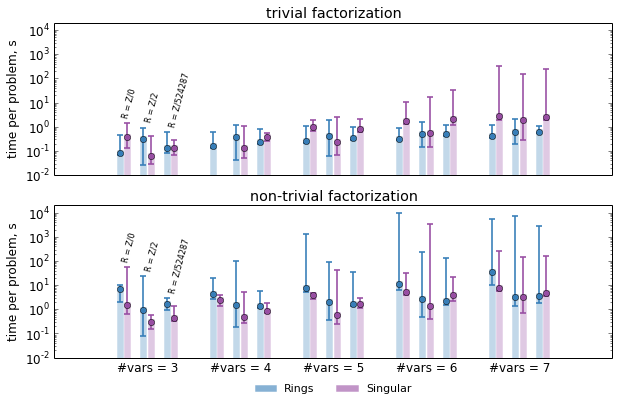

In [125]:
f, (ax_trivial, ax) = plt.subplots(2, sharex=True, figsize=(2 * 5, 3 * 2))

plot_nvars_dep(True, ax = ax_trivial, show_legend=False, show_x_ticks=False)
ax_trivial.set_title('trivial factorization')

plot_nvars_dep(False, ax = ax)
ax.set_title('non-trivial factorization')

plt.savefig('factor.pdf', bbox_inches='tight')

In [132]:
def plot_scatter(nvars, char, trivial, ax = None):
    if ax is None:
        plt.figure(figsize=(5, 4)) 
        ax = plt.gca()

    selection = statistics[(statistics.nvars == nvars) & (statistics.char == char) & (statistics.trivial == trivial)]
    selection = selection.dropna()
    # from nanoseconds to seconds
    selection[['Rings', 'Singular']] = selection[['Rings', 'Singular']] / 1e9
    minval = selection[['Rings', 'Singular']].min().min()
    maxval = selection[['Rings', 'Singular']].max().max()
    
    ax.set_xlim([minval / 2, 3 * maxval])
    ax.set_ylim([minval / 2, 3 * maxval])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel('Singular, s')
    ax.set_xlabel('Rings, s')
    
    ax.scatter(selection['Rings'], selection['Singular'])
    ax.plot([minval / 2, 2 * maxval], [minval / 2, 2 * maxval], linestyle='--', c='grey')

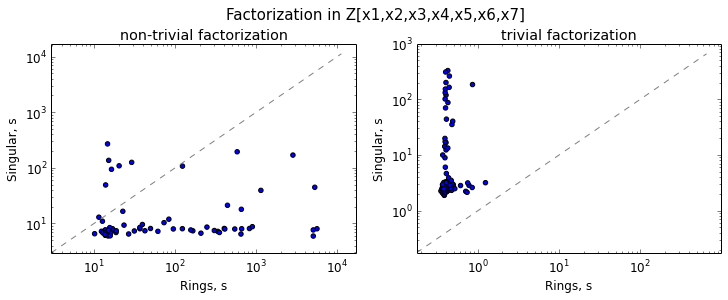

In [154]:
nvars = 7
char = 0
f, (ax, ax_trivial) = plt.subplots(nrows=1, ncols = 2, figsize=(2 * 6, 4))

plot_scatter(nvars, char, False, ax = ax)
ax.set_title('non-trivial factorization')

plot_scatter(nvars, char, True, ax = ax_trivial)
ax_trivial.set_title('trivial factorization')

plt.suptitle('Factorization in Z[x1,x2,x3,x4,x5,x6,x7]', fontsize=15)
f.subplots_adjust(top=0.85)

plt.savefig('factor_scatter.pdf', bbox_inches='tight')